0. Load Data + Calculated Embeddings

In [4]:
# Load the three datasets.
import pandas as pd

df_base = pd.read_csv('C:/Users/qhaskovec/OneDrive/GitHub/PhD-Thesis-EU-Solidarity-Statements/EUSpeech_translated_preprocessed_not_about_self.csv')
df_add2 = pd.read_csv('C:/Users/qhaskovec/OneDrive/GitHub/PhD-Thesis-EU-Solidarity-Statements/Embeddings_all_mpnet_base_v2.csv')

# Merge the additional datasets into the base dataset using the 'context' column.
# We use a left join to keep all rows from the base dataset.
df_s = pd.merge(df_base, df_add2, on="matched_sentence", how="left")
 

In [5]:
df_nonempty = df_s[df_s['embedding'].apply(lambda x: pd.notna(x))]


1. Sentence Embeddings

1.1 Calculate Sentence Embeddings

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained SentenceBERT model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')#Depends on the embedding
from tqdm import tqdm
tqdm.pandas()  # this adds the progress_apply method to pandas

# Apply to the Dataset
df["embedding"] = df["context"].progress_apply(lambda s: model.encode(s))


1.1 Calculate Centroids for the Different Groups

In [18]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# --- Step 1: Convert embedding strings to numpy arrays if necessary ---
# Assume df_nonempty is defined. Check type of first embedding.
if isinstance(df_nonempty.iloc[0]['embedding'], str):
    df_nonempty['embedding'] = df_nonempty['embedding'].apply(
        lambda s: np.array([float(x) for x in s.strip('[]').split()])
    )

# --- Step 2: Iterate over each year and compute cosine similarity ---
years = sorted(df_nonempty['year'].unique())
results = []

for year in years:
    # Select data for the current year
    df_year = df_nonempty[df_nonempty['year'] == year]
    
    # Filter rows with non-empty EU_2004 and West_EU_member groups
    df_year_eu2004 = df_year[df_year['Eastern_Partnership'].notnull() & (df_year['Eastern_Partnership'] != '')]
    df_year_west_eu = df_year[df_year['West_EU_member'].notnull() & (df_year['West_EU_member'] != '')]
    
    # If either group is empty for the current year, record NaN
    if df_year_eu2004.empty or df_year_west_eu.empty:
        results.append((year, np.nan))
    else:
        # Compute centroids for each group by stacking embeddings and taking the mean
        centroid_eu2004 = np.mean(np.vstack(df_year_eu2004['embedding'].values), axis=0)
        centroid_west_eu = np.mean(np.vstack(df_year_west_eu['embedding'].values), axis=0)
        
        # Calculate cosine similarity between the two centroids
        sim = cosine_similarity(centroid_eu2004.reshape(1, -1), 
                                centroid_west_eu.reshape(1, -1))[0][0]
        results.append((year, sim))

# --- Step 3: Store the results in a DataFrame and display ---
similarity_df = pd.DataFrame(results, columns=['year', 'cosine_similarity'])
print(similarity_df)


    year  cosine_similarity
0   1995                NaN
1   1996           0.505286
2   1997           0.672588
3   1998           0.691187
4   1999           0.570926
5   2000           0.658938
6   2001           0.460304
7   2002           0.537749
8   2003           0.468082
9   2004           0.548112
10  2005           0.597615
11  2006           0.527281
12  2007           0.676421
13  2008           0.689235
14  2009           0.710087
15  2010           0.655698
16  2011           0.500530
17  2012           0.584359
18  2013           0.650086
19  2014           0.551634
20  2015           0.678655
21  2016           0.745051
22  2017           0.746998
23  2018           0.663116
24  2019           0.637807
25  2020           0.666005
26  2021           0.714166
27  2022           0.715578
28  2023           0.691477
29  2024           0.367365


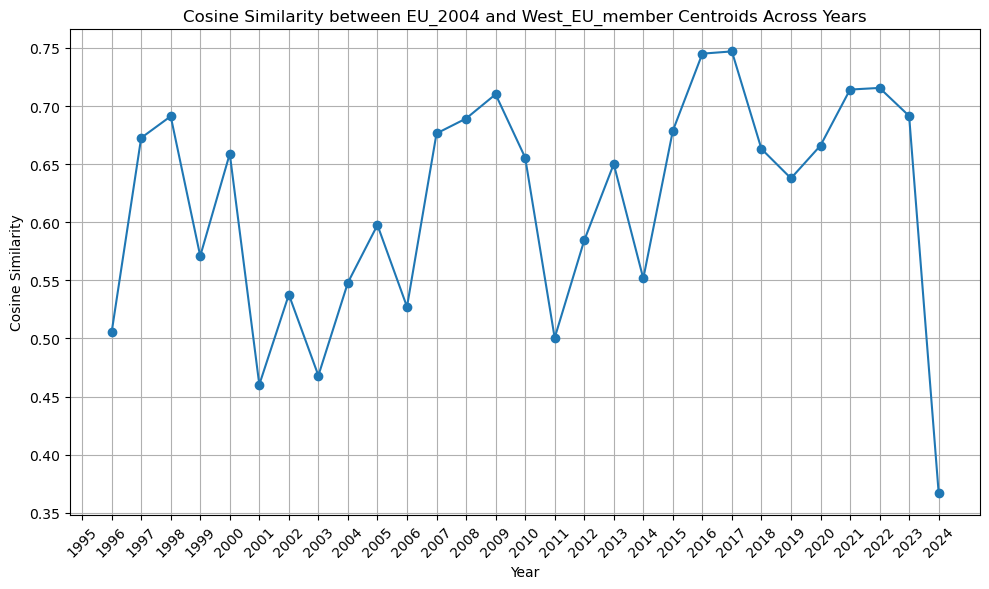

In [19]:
import matplotlib.pyplot as plt

# Convert year to string if needed (for proper x-axis labeling)
similarity_df['year'] = similarity_df['year'].astype(str)

plt.figure(figsize=(10, 6))
plt.plot(similarity_df['year'], similarity_df['cosine_similarity'], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Cosine Similarity")
plt.title("Cosine Similarity between EU_2004 and West_EU_member Centroids Across Years")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

1.2 Not Comparing Centroid but averaging comparison to a centroid

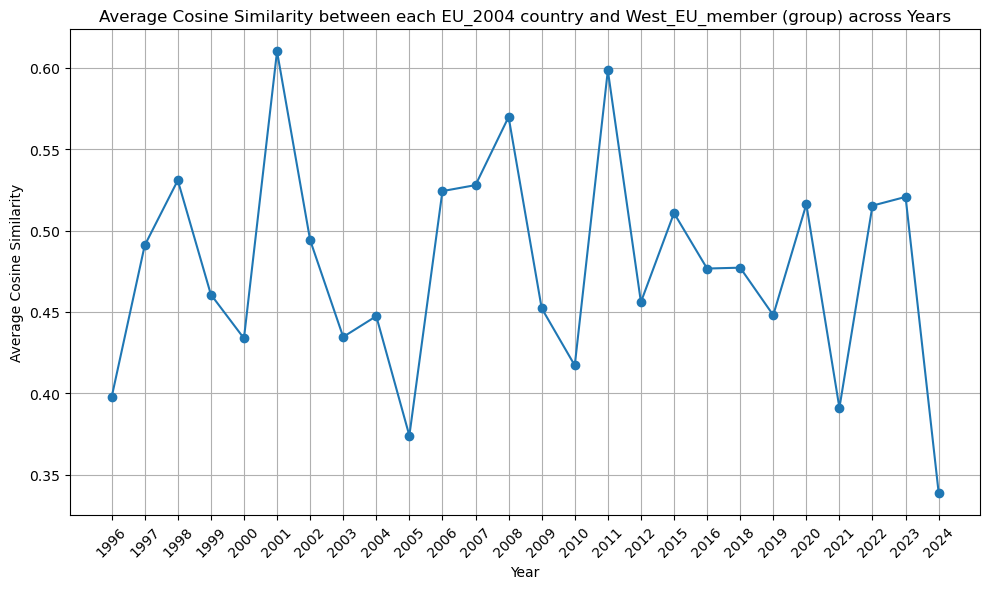

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --- Step 0: Ensure embeddings are numeric arrays ---
# (If the first embedding is a string, convert all.)
if isinstance(df_nonempty.iloc[0]['embedding'], str):
    df_nonempty['embedding'] = df_nonempty['embedding'].apply(
        lambda s: np.array([float(x) for x in s.strip('[]').split()])
    )

# --- Step 1: Prepare to iterate over each year ---
years = sorted(df_nonempty['year'].unique())
results = []  # This will hold tuples of (year, average_cosine_similarity)

for year in years:
    # Subset the DataFrame for this year.
    df_year = df_nonempty[df_nonempty['year'] == year]
    
    # --- West_EU_member Group ---
    # Filter rows where West_EU_member is non-empty.
    df_west = df_year[(df_year['West_EU_member'].notnull()) & (df_year['West_EU_member'] != '')]
    if df_west.empty:
        continue  # Skip this year if there are no West_EU_member rows.
    
    # Compute the centroid for West_EU_member embeddings.
    west_embeddings = np.vstack(df_west['embedding'].values)
    west_centroid = np.mean(west_embeddings, axis=0)
    
    # --- EU_2004 Group ---
    # Filter rows where EU_2004 is non-empty.
    df_eu = df_year[(df_year['EU_2007'].notnull()) & (df_year['EU_2007'] != '')]
    if df_eu.empty:
        continue  # Skip if no EU_2004 rows.
    
    # Explode the EU_2004 column so each row has a single EU_2004 country.
    df_eu_exploded = df_eu.copy()
    df_eu_exploded['EU2004_country'] = df_eu_exploded['EU_2007'].apply(
        lambda x: [country.strip() for country in x.split(',')]
    )
    df_eu_exploded = df_eu_exploded.explode('EU2004_country')
    
    # --- Step 2: Compute cosine similarity for each EU_2004 mention ---
    sims = []
    for idx, row in df_eu_exploded.iterrows():
        emb = row['embedding']
        sim = cosine_similarity(emb.reshape(1, -1), west_centroid.reshape(1, -1))[0][0]
        sims.append(sim)
    
    # Average the cosine similarities for this year.
    if len(sims) > 0:
        avg_sim = np.mean(sims)
        results.append((year, avg_sim))

# --- Step 3: Create a DataFrame with the results and plot ---
similarity_df = pd.DataFrame(results, columns=['year', 'avg_cosine_similarity'])
similarity_df = similarity_df.sort_values('year')

plt.figure(figsize=(10, 6))
plt.plot(similarity_df['year'].astype(str), similarity_df['avg_cosine_similarity'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity between each EU_2004 country and West_EU_member (group) across Years')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


1.3 Same as above but disaggregated into countries 

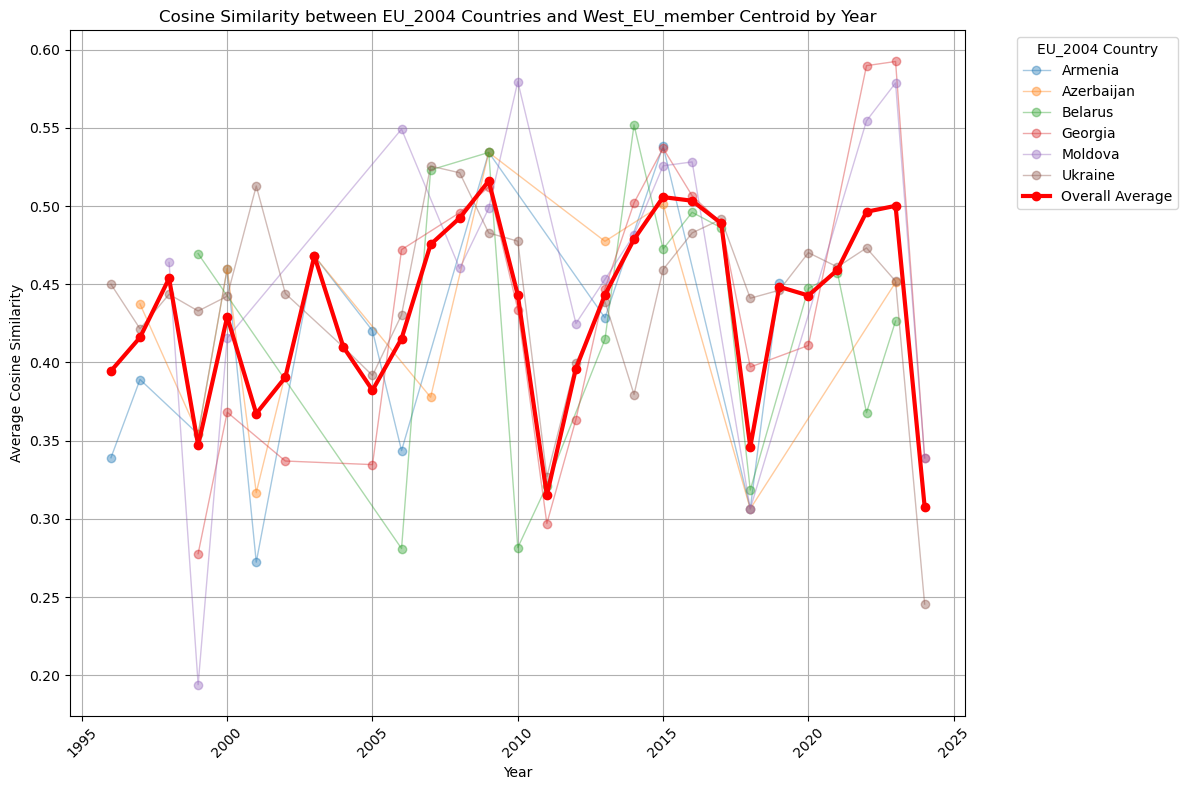

In [22]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
df_nonempty = df_nonempty[df_nonempty['country'].str.lower() != 'poland']
# --- Step 1: Convert embedding strings to NumPy arrays if needed ---
# (Assumes that if the first embedding is a string, then all are strings.)
if isinstance(df_nonempty.iloc[0]['embedding'], str):
    df_nonempty['embedding'] = df_nonempty['embedding'].apply(
        lambda s: np.array([float(x) for x in s.strip('[]').split()])
    )

# --- Step 2: Initialize a list to collect the results ---
results = []  # each element will be a tuple: (year, EU_2004_country, avg_cosine_similarity)

# Get unique years (sorted)
years = sorted(df_nonempty['year'].unique())

# --- Step 3: Loop over each year ---
for year in years:
    # Subset the DataFrame for this year.
    df_year = df_nonempty[df_nonempty['year'] == year]
    
    # Compute West_EU_member centroid for this year
    df_west = df_year[(df_year['West_EU_member'].notnull()) & (df_year['West_EU_member'] != '')]
    if df_west.empty:
        continue  # Skip if no West_EU_member rows for this year.
    west_embeddings = np.vstack(df_west['embedding'].values)
    west_centroid = np.mean(west_embeddings, axis=0)
    
    # Filter and explode the EU_2004 group
    df_eu = df_year[(df_year['Eastern_Partnership'].notnull()) & (df_year['Eastern_Partnership'] != '')].copy()
    if df_eu.empty:
        continue  # Skip if no EU_2004 rows for this year.
    
    # Explode EU_2004 into separate country mentions.
    df_eu['EU2004_country'] = df_eu['Eastern_Partnership'].apply(lambda x: [country.strip() for country in x.split(',')])
    df_eu_exploded = df_eu.explode('EU2004_country')
    
    # For each EU_2004 country in this year, compute cosine similarities with the West_EU_member centroid.
    for country in df_eu_exploded['EU2004_country'].unique():
        df_country = df_eu_exploded[df_eu_exploded['EU2004_country'] == country]
        similarities = []
        for idx, row in df_country.iterrows():
            emb = row['embedding']
            sim = cosine_similarity(emb.reshape(1, -1), west_centroid.reshape(1, -1))[0][0]
            similarities.append(sim)
        if similarities:
            avg_sim = np.mean(similarities)
            results.append((year, country, avg_sim))

# --- Step 4: Convert results to a DataFrame ---
similarity_by_country_df = pd.DataFrame(results, columns=['year', 'EU2004_country', 'avg_cosine_similarity'])
similarity_by_country_df = similarity_by_country_df.sort_values('year')

# --- Step 5: Compute overall average across all EU_2004 countries for each year ---
overall_avg_df = similarity_by_country_df.groupby('year')['avg_cosine_similarity'].mean().reset_index()

# --- Step 6: Plot the individual country lines (low visibility) and the overall average (high visibility) ---
plt.figure(figsize=(12, 8))

# Plot individual country lines with low alpha and thinner lines.
for country, group in similarity_by_country_df.groupby('EU2004_country'):
    group = group.sort_values('year')
    plt.plot(group['year'], group['avg_cosine_similarity'], marker='o', linestyle='-', alpha=0.4, linewidth=1, label=country)

# Plot overall average line with high visibility.
plt.plot(overall_avg_df['year'], overall_avg_df['avg_cosine_similarity'], marker='o', linestyle='-', 
         color='red', linewidth=3, label='Overall Average')

plt.xlabel('Year')
plt.ylabel('Average Cosine Similarity')
plt.title('Cosine Similarity between EU_2004 Countries and West_EU_member Centroid by Year')
plt.xticks(rotation=45)
plt.legend(title='EU_2004 Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


2. Word Embeddings

2.1 Train Word Embedding Model

In [ ]:
df = pd.read_csv('C:/Users/qhaskovec/OneDrive/GitHub/PhD-Thesis-EU-Solidarity-Statements/EUSpeech_translated_preprocessed_not_blown_up.csv')
df = df[
    df.apply(lambda row: row['country'] not in row['matched_keyword'], axis=1)
] #so it is not about self

In [29]:
from gensim.models import Word2Vec

# Group by year
yearly_models = {}

for year, group in df.groupby('year'):
    tokenized_texts = group['tokenized'].tolist()
    model = Word2Vec(tokenized_texts, vector_size=100, window=20, min_count=3, workers=4)
    yearly_models[year] = model


In [33]:
    # Define category lists.
EU_member_list = [
    "Austria", "Belgium", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark",
    "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy",
    "Latvia", "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal",
    "Romania", "Slovakia", "Slovenia", "Spain", "Sweden"
]
West_EU_members = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_2004_list = ["Czech Republic", "Estonia", "Cyprus", "Latvia", "Lithuania", "Hungary", "Malta", "Poland", "Slovakia", "Slovenia"]
EU_2007_list = ["Bulgaria", "Romania"]
EU_2013_list = ["Croatia"]
Accession_list = ["Albania", "Montenegro", "North Macedonia", "Serbia", "Turkey"]
Eastern_Partnership_list = ["Armenia", "Azerbaijan", "Belarus", "Georgia", "Moldova", "Ukraine"]
Global_powers_list = ["USA", "US", "United States", "America", "Russia", "China"]
categories = {
    "EU_members": EU_member_list,
    "West_EU": West_EU_members,
    "EU_2004": EU_2004_list,
    "EU_2007": EU_2007_list,
    "EU_2013": EU_2013_list,
    "Accession": Accession_list,
    "Eastern_Partnership": Eastern_Partnership_list,
    "Global_powers": Global_powers_list
}   

from itertools import combinations
import numpy as np

def get_avg_similarity(model, words):
    words_in_vocab = [w.lower() for w in words if w.lower() in model.wv]
    if len(words_in_vocab) < 2:
        return None
    sims = []
    for w1, w2 in combinations(words_in_vocab, 2):
        sims.append(model.wv.similarity(w1, w2))
    return np.mean(sims) if sims else None

IndentationError: expected an indented block after function definition on line 29 (3479198021.py, line 30)